In [0]:
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, MaxoutDense, SpatialDropout1D
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.layers.advanced_activations import PReLU
from keras.regularizers import l1
from keras.constraints import max_norm
import os
import matplotlib.pyplot as plt
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

**Setting up default parameters**

In [0]:
batch_size = 256
num_classes = 10
epochs = 100
data_augmentation = True
#num_predictions = 20
#save_dir = os.path.join(os.getcwd(), 'saved_models')
#model_name = 'keras_cifar10_trained_model.h5'

##Loading Dataset

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170500096/170498071 [==============================] - 305s 2us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


###Converting the classes to categories

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

**Converting the datatype to float for normalization purposes**

In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

**These methods plots the graphs of**
- Train accuracy along with Validation accuracy
- Train loss along with validation loss

In [0]:
def plotAccuracy(history):
  plt.plot(history['acc'])
  plt.plot(history['val_acc'])
  plt.title('Model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  
def plotLoss(history):
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper right')
  plt.show()

###Base CNN model

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [124]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_136 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_133 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_137 (Conv2D)          (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_134 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_138 (Conv2D)          (None, 15, 15, 64)        18496     
__________

In [0]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

###Data Augmentation using keras pre-processing

In [8]:
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

Using real-time data augmentation.


In [0]:
if data_augmentation:
  datagen.fit(x_train)

In [34]:
if data_augmentation:
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                    validation_data=(x_test, y_test), workers=4)

Epoch 1/100
1563/1563 [==============================] - 48s 31ms/step - loss: 1.8810 - acc: 0.3052 - val_loss: 1.6147 - val_acc: 0.4111
Epoch 2/100
1563/1563 [==============================] - 45s 29ms/step - loss: 1.6015 - acc: 0.4114 - val_loss: 1.3960 - val_acc: 0.4987
Epoch 3/100
1563/1563 [==============================] - 47s 30ms/step - loss: 1.4838 - acc: 0.4596 - val_loss: 1.3762 - val_acc: 0.5030
Epoch 4/100
1563/1563 [==============================] - 47s 30ms/step - loss: 1.4054 - acc: 0.4930 - val_loss: 1.2646 - val_acc: 0.5490
Epoch 5/100
1563/1563 [==============================] - 48s 31ms/step - loss: 1.3399 - acc: 0.5183 - val_loss: 1.1981 - val_acc: 0.5696
Epoch 6/100
1563/1563 [==============================] - 47s 30ms/step - loss: 1.2859 - acc: 0.5420 - val_loss: 1.2441 - val_acc: 0.5541
Epoch 7/100
1563/1563 [==============================] - 47s 30ms/step - loss: 1.2340 - acc: 0.5598 - val_loss: 1.0717 - val_acc: 0.6242
Epoch 8/100
1563/1563 [==================

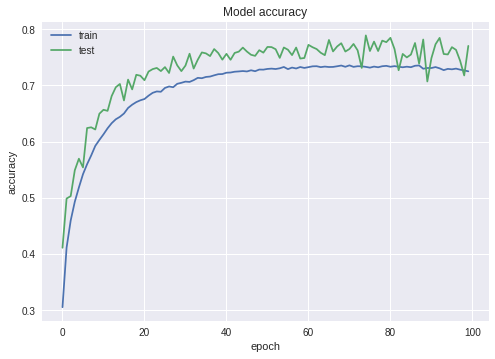

In [35]:
plotAccuracy(history.history)

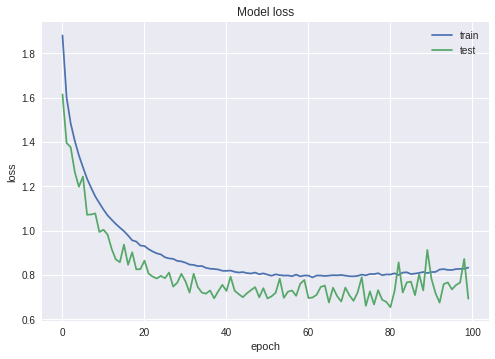

In [36]:
plotLoss(history.history)

**The base model is underfitting and so there are chances of improvements. Varying the network layers can improve the model.**

###Config 1 - Removing Dropout layers as there is no overfitting

In [0]:
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
#model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
#model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(512))
model1.add(Activation('relu'))
#model1.add(Dropout(0.5))
model1.add(Dense(num_classes))
model1.add(Activation('softmax'))

In [125]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_139 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_140 (Activation)  (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 15, 15, 64)        18496     
_________________________________________________________________
activation_141 (Activation)  (None, 15, 15, 64)        0         
__________

In [0]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [39]:
history1 = model1.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                    validation_data=(x_test, y_test), workers=4)

Epoch 1/100
1563/1563 [==============================] - 48s 31ms/step - loss: 1.7168 - acc: 0.3816 - val_loss: 1.4347 - val_acc: 0.4835
Epoch 2/100
1563/1563 [==============================] - 48s 31ms/step - loss: 1.4461 - acc: 0.4830 - val_loss: 1.2740 - val_acc: 0.5465
Epoch 3/100
1563/1563 [==============================] - 48s 31ms/step - loss: 1.3232 - acc: 0.5302 - val_loss: 1.1586 - val_acc: 0.5906
Epoch 4/100
1563/1563 [==============================] - 47s 30ms/step - loss: 1.2295 - acc: 0.5646 - val_loss: 1.0996 - val_acc: 0.6106
Epoch 5/100
1563/1563 [==============================] - 47s 30ms/step - loss: 1.1547 - acc: 0.5952 - val_loss: 1.0431 - val_acc: 0.6284
Epoch 6/100
1563/1563 [==============================] - 48s 31ms/step - loss: 1.0969 - acc: 0.6132 - val_loss: 0.9777 - val_acc: 0.6565
Epoch 7/100
1563/1563 [==============================] - 48s 31ms/step - loss: 1.0480 - acc: 0.6352 - val_loss: 0.9761 - val_acc: 0.6631
Epoch 8/100
1563/1563 [==================

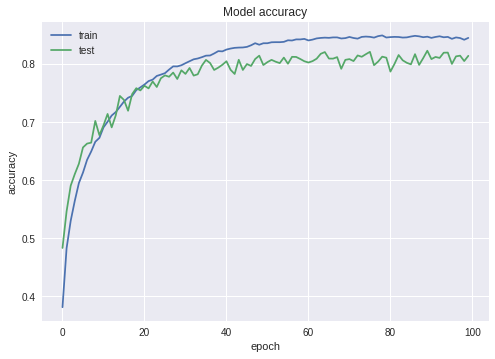

In [40]:
plotAccuracy(history1.history)

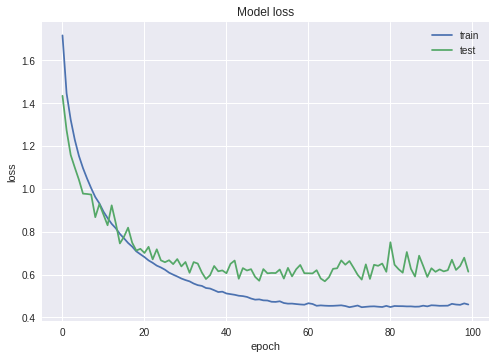

In [41]:
plotLoss(history1.history)

**The plot shows that now the model is not overfitting but if more number of epochs are executed, the model will definitly overfit as the validation loss is starting to increase but training loss is decreasing**

### Config 2 - increassing the number of neurons in conv2d layers

In [0]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
#model2.add(Dropout(0.2))

model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(256, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
#model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
#model2.add(Dropout(0.5))
model2.add(Dense(num_classes))
model2.add(Activation('softmax'))

In [126]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_144 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_145 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_145 (Conv2D)          (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_146 (Activation)  (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_68 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_146 (Conv2D)          (None, 15, 15, 128)       73856     
_________________________________________________________________
activation_147 (Activation)  (None, 15, 15, 128)       0         
__________

In [129]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history2 = model2.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 34s 172ms/step - loss: 1.8444 - acc: 0.3386 - val_loss: 1.6587 - val_acc: 0.4083
Epoch 2/100
196/196 [==============================] - 30s 152ms/step - loss: 1.6000 - acc: 0.4250 - val_loss: 1.5043 - val_acc: 0.4691
Epoch 3/100
196/196 [==============================] - 31s 159ms/step - loss: 1.4899 - acc: 0.4651 - val_loss: 1.3357 - val_acc: 0.5276
Epoch 4/100
196/196 [==============================] - 30s 154ms/step - loss: 1.4126 - acc: 0.4957 - val_loss: 1.3286 - val_acc: 0.5289
Epoch 5/100
196/196 [==============================] - 30s 154ms/step - loss: 1.3459 - acc: 0.5231 - val_loss: 1.2570 - val_acc: 0.5508
Epoch 6/100
196/196 [==============================] - 31s 156ms/step - loss: 1.2879 - acc: 0.5466 - val_loss: 1.3285 - val_acc: 0.5378
Epoch 7/100
196/196 [==============================] - 30s 154ms/step - loss: 1.2318 - acc: 0.5670 - val_loss: 1.1885 - val_acc: 0.5809
Epoch 8/100
196/196 [===========================

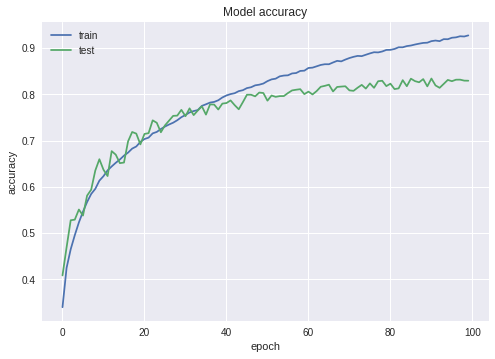

In [130]:
plotAccuracy(history2.history)

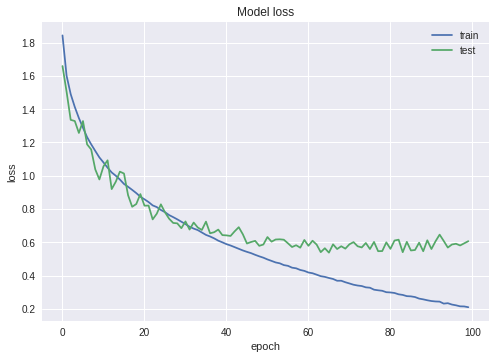

In [131]:
plotLoss(history2.history)

**There is an increase in the validation loss and training loss difference. The model is overfitting.**

### Config 3 - Adding Spatial Dropout layer

In [0]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(SpatialDropout2D(0.2))

model3.add(Conv2D(128, (3, 3), padding='same'))
model3.add(Activation('relu'))
model3.add(Conv2D(256, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(SpatialDropout2D(0.2))

model3.add(Flatten())
model3.add(Dense(512))
model3.add(Activation('relu'))
model3.add(Dropout(0.2))
model3.add(Dense(num_classes))
model3.add(Activation('softmax'))

In [127]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_148 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
activation_151 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_149 (Conv2D)          (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_152 (Activation)  (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
spatial_dropout2d_66 (Spatia (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_150 (Conv2D)          (None, 15, 15, 128)       73856     
__________

In [14]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history3 = model3.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 33s 171ms/step - loss: 1.9163 - acc: 0.3071 - val_loss: 1.6038 - val_acc: 0.4314
Epoch 2/100
196/196 [==============================] - 29s 150ms/step - loss: 1.6617 - acc: 0.4077 - val_loss: 1.4742 - val_acc: 0.4773
Epoch 3/100
196/196 [==============================] - 29s 149ms/step - loss: 1.5523 - acc: 0.4416 - val_loss: 1.3720 - val_acc: 0.5154
Epoch 4/100
196/196 [==============================] - 29s 149ms/step - loss: 1.4724 - acc: 0.4727 - val_loss: 1.2857 - val_acc: 0.5370
Epoch 5/100
196/196 [==============================] - 30s 155ms/step - loss: 1.4069 - acc: 0.4977 - val_loss: 1.2103 - val_acc: 0.5699
Epoch 6/100
196/196 [==============================] - 29s 149ms/step - loss: 1.3543 - acc: 0.5182 - val_loss: 1.1749 - val_acc: 0.5907
Epoch 7/100
196/196 [==============================] - 29s 148ms/step - loss: 1.3037 - acc: 0.5373 - val_loss: 1.1457 - val_acc: 0.5969
Epoch 8/100
196/196 [===========================

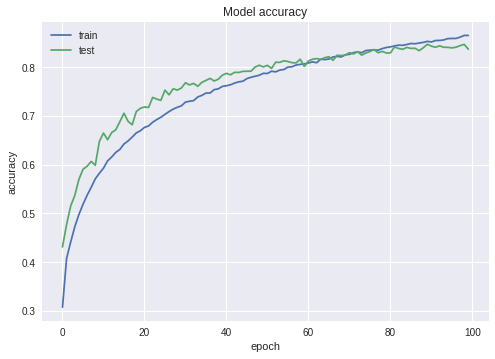

In [15]:
plotAccuracy(history3.history)

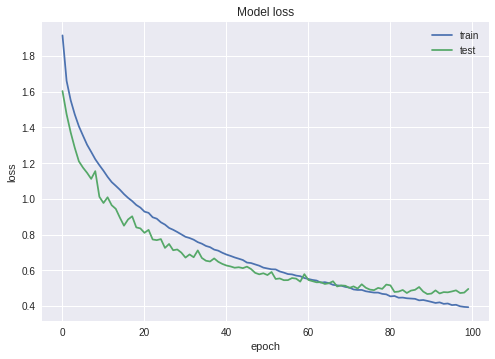

In [16]:
plotLoss(history3.history)

**This model is definitly better than previous configurations. The addition of Spatial dropout layers with 20% dropout rate is avoid the model to overfit during higher epochs. 
Spatial dropout 2d performs the same function as Dropout, however it drops entire 2D feature maps instead of individual elements. If adjacent pixels within feature maps are strongly correlated then regular dropout will not regularize the activations and will otherwise just result in an effective learning rate decrease. In this case, SpatialDropout2D will help promote independence between feature maps and should be used instead.**

### Config 4 - Removing activation layers

In [0]:
model4 = Sequential()
model4.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
#model4.add(Activation('relu'))
model4.add(Conv2D(64, (3, 3)))
#model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(SpatialDropout2D(0.2))

model4.add(Conv2D(128, (3, 3), padding='same'))
#model4.add(Activation('relu'))
model4.add(Conv2D(256, (3, 3)))
#model4.add(Activation('relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(SpatialDropout2D(0.2))

model4.add(Flatten())
model4.add(Dense(512))
model4.add(Activation('relu'))
model4.add(Dropout(0.2))
model4.add(Dense(num_classes))
model4.add(Activation('softmax'))

In [113]:
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 30, 30, 64)        18496     
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
spatial_dropout2d_51 (Spatia (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 13, 13, 256)       295168    
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 6, 6, 256)         0         
__________

In [76]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history4 = model4.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 33s 168ms/step - loss: 1.8222 - acc: 0.3463 - val_loss: 1.5254 - val_acc: 0.4606
Epoch 2/100
196/196 [==============================] - 31s 157ms/step - loss: 1.5760 - acc: 0.4415 - val_loss: 1.4422 - val_acc: 0.4939
Epoch 3/100
196/196 [==============================] - 30s 154ms/step - loss: 1.4467 - acc: 0.4870 - val_loss: 1.3075 - val_acc: 0.5442
Epoch 4/100
196/196 [==============================] - 31s 160ms/step - loss: 1.3636 - acc: 0.5233 - val_loss: 1.2378 - val_acc: 0.5637
Epoch 5/100
196/196 [==============================] - 30s 155ms/step - loss: 1.2999 - acc: 0.5441 - val_loss: 1.1359 - val_acc: 0.6098
Epoch 6/100
196/196 [==============================] - 30s 154ms/step - loss: 1.2439 - acc: 0.5627 - val_loss: 1.0703 - val_acc: 0.6270
Epoch 7/100
196/196 [==============================] - 31s 156ms/step - loss: 1.1963 - acc: 0.5837 - val_loss: 1.0496 - val_acc: 0.6369
Epoch 8/100
196/196 [===========================

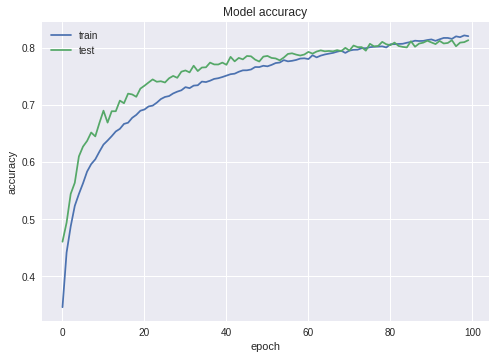

In [77]:
plotAccuracy(history4.history)

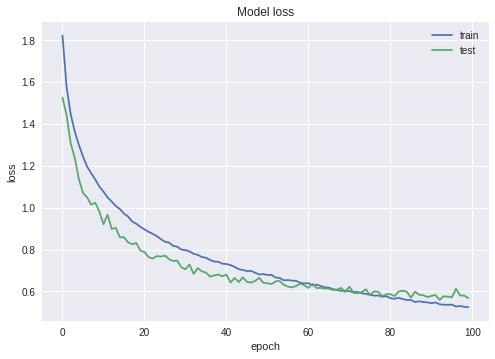

In [78]:
plotLoss(history4.history)

**This is weird behaviour. It shows that adding non-linearity to the conv layers is bad for the model stability. Looks like the Spatial Dropout layer might be the reason because of which the model doesn't feel the need of activation layer.**

###Config 5 - Trying MaxoutDense layer(Deprecated now)

In [71]:
model5 = Sequential()
model5.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model5.add(Activation('relu'))
model5.add(Conv2D(64, (3, 3)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(SpatialDropout2D(0.2))

model5.add(Conv2D(128, (3, 3), padding='same'))
model5.add(Activation('relu'))
model5.add(Conv2D(256, (3, 3)))
model5.add(Activation('relu'))
model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(SpatialDropout2D(0.2))

model5.add(Flatten())
model5.add(MaxoutDense(512))
model5.add(Activation('relu'))
model4.add(Dropout(0.2))
model5.add(MaxoutDense(num_classes))
model5.add(Activation('softmax'))

/usr/local/lib/python3.6/dist-packages/keras/legacy/layers.py:534: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


In [112]:
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_97 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_119 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
activation_120 (Activation)  (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
spatial_dropout2d_49 (Spatia (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 15, 15, 128)       73856     
__________

In [72]:
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
model5.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history5 = model5.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 35s 176ms/step - loss: 2.2640 - acc: 0.1679 - val_loss: 2.1923 - val_acc: 0.2530
Epoch 2/100
196/196 [==============================] - 32s 164ms/step - loss: 2.1328 - acc: 0.2446 - val_loss: 2.0150 - val_acc: 0.3132
Epoch 3/100
196/196 [==============================] - 32s 165ms/step - loss: 2.0221 - acc: 0.2817 - val_loss: 1.9094 - val_acc: 0.3395
Epoch 4/100
196/196 [==============================] - 33s 166ms/step - loss: 1.9467 - acc: 0.3092 - val_loss: 1.8323 - val_acc: 0.3668
Epoch 5/100
196/196 [==============================] - 32s 165ms/step - loss: 1.8802 - acc: 0.3369 - val_loss: 1.7661 - val_acc: 0.3843
Epoch 6/100
196/196 [==============================] - 32s 165ms/step - loss: 1.8223 - acc: 0.3552 - val_loss: 1.7141 - val_acc: 0.3922
Epoch 7/100
196/196 [==============================] - 32s 165ms/step - loss: 1.7768 - acc: 0.3713 - val_loss: 1.6917 - val_acc: 0.3979
Epoch 8/100
196/196 [===========================

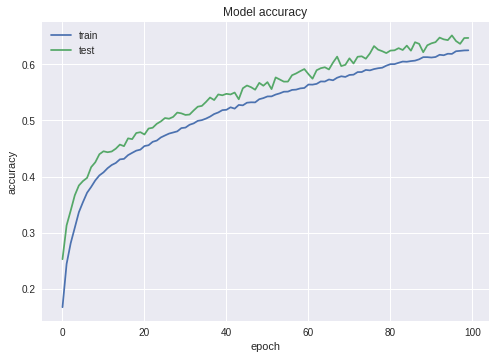

In [73]:
plotAccuracy(history5.history)

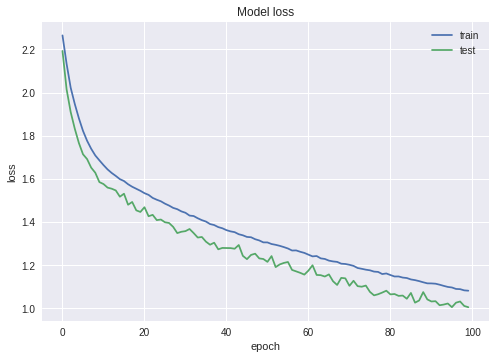

In [74]:
plotLoss(history5.history)

**No wonder why it was deprecated. The function of Maxout Dense and TimeDistributed dense layers are now combined in Dense layer and so the former 2 are deprecated since keras 2.0**

###Config 6 - PReLU activation with additional Dense layer

In [0]:
model6 = Sequential()
model6.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model6.add(PReLU())
model6.add(Conv2D(64, (3, 3)))
model6.add(PReLU())
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(SpatialDropout2D(0.2))

model6.add(Conv2D(128, (3, 3), padding='same'))
model6.add(PReLU())
model6.add(Conv2D(256, (3, 3)))
model6.add(PReLU())
model6.add(MaxPooling2D(pool_size=(2, 2)))
model6.add(SpatialDropout2D(0.2))

model6.add(Flatten())
model6.add(Dense(512))
model6.add(PReLU())
model6.add(Dropout(0.2))
model6.add(Dense(1024))
model6.add(PReLU())
model6.add(Dropout(0.2))
model6.add(Dense(num_classes))
model6.add(Activation('softmax'))

In [110]:
model6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_105 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 30, 30, 64)        18496     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 30, 30, 64)        57600     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
spatial_dropout2d_53 (Spatia (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 15, 15, 128)       73856     
__________

In [80]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model6.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history6 = model6.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 37s 189ms/step - loss: 2.0010 - acc: 0.2660 - val_loss: 1.7388 - val_acc: 0.3725
Epoch 2/100
196/196 [==============================] - 34s 172ms/step - loss: 1.7339 - acc: 0.3740 - val_loss: 1.6066 - val_acc: 0.4221
Epoch 3/100
196/196 [==============================] - 34s 173ms/step - loss: 1.6267 - acc: 0.4131 - val_loss: 1.4439 - val_acc: 0.4726
Epoch 4/100
196/196 [==============================] - 34s 173ms/step - loss: 1.5335 - acc: 0.4476 - val_loss: 1.3525 - val_acc: 0.5120
Epoch 5/100
196/196 [==============================] - 34s 174ms/step - loss: 1.4573 - acc: 0.4763 - val_loss: 1.2480 - val_acc: 0.5551
Epoch 6/100
196/196 [==============================] - 34s 174ms/step - loss: 1.3956 - acc: 0.4996 - val_loss: 1.2008 - val_acc: 0.5745
Epoch 7/100
196/196 [==============================] - 34s 173ms/step - loss: 1.3330 - acc: 0.5223 - val_loss: 1.1420 - val_acc: 0.5978
Epoch 8/100
196/196 [===========================

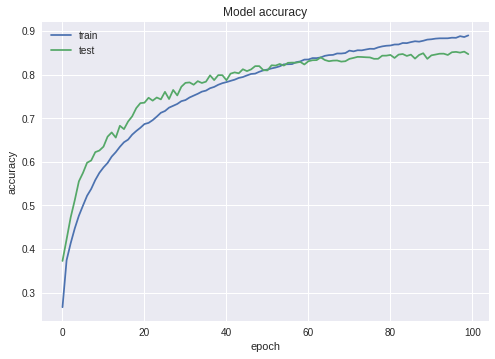

In [81]:
plotAccuracy(history6.history)

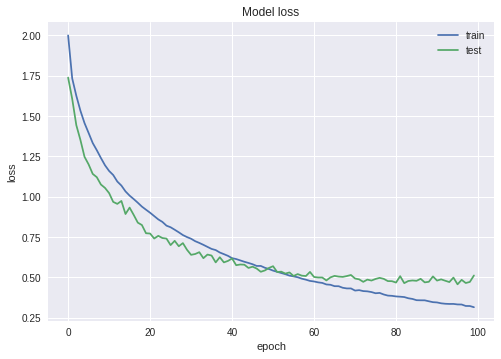

In [82]:
plotLoss(history6.history)

**Sufficient increase in the model accuracy and less difference in model losses. However, the model seems to be overfitting as the plots have huge difference in slopes.**

###Config 7 - Trying AveragePooling layer to avoid overfitting

In [0]:
model7 = Sequential()
model7.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model7.add(PReLU())
model7.add(Conv2D(64, (3, 3)))
model7.add(PReLU())
model7.add(AveragePooling2D(pool_size=(2, 2)))
model7.add(SpatialDropout2D(0.2))

model7.add(Conv2D(128, (3, 3), padding='same'))
model7.add(PReLU())
model7.add(Conv2D(256, (3, 3)))
model7.add(PReLU())
model7.add(AveragePooling2D(pool_size=(2, 2)))
model7.add(SpatialDropout2D(0.2))

model7.add(Flatten())
model7.add(Dense(512))
model7.add(PReLU())
model7.add(Dropout(0.2))
model7.add(Dense(1024))
model7.add(PReLU())
model7.add(Dropout(0.2))
model7.add(Dense(num_classes))
model7.add(Activation('softmax'))

In [109]:
model7.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_109 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 30, 30, 64)        18496     
_________________________________________________________________
p_re_lu_8 (PReLU)            (None, 30, 30, 64)        57600     
_________________________________________________________________
average_pooling2d_1 (Average (None, 15, 15, 64)        0         
_________________________________________________________________
spatial_dropout2d_55 (Spatia (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 15, 15, 128)       73856     
__________

In [84]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model7.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history7 = model7.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 37s 190ms/step - loss: 1.9997 - acc: 0.2660 - val_loss: 1.7309 - val_acc: 0.3940
Epoch 2/100
196/196 [==============================] - 34s 171ms/step - loss: 1.7510 - acc: 0.3698 - val_loss: 1.5860 - val_acc: 0.4350
Epoch 3/100
196/196 [==============================] - 34s 171ms/step - loss: 1.6460 - acc: 0.4059 - val_loss: 1.4814 - val_acc: 0.4631
Epoch 4/100
196/196 [==============================] - 34s 172ms/step - loss: 1.5731 - acc: 0.4308 - val_loss: 1.4374 - val_acc: 0.4876
Epoch 5/100
196/196 [==============================] - 33s 171ms/step - loss: 1.5098 - acc: 0.4536 - val_loss: 1.3428 - val_acc: 0.5072
Epoch 6/100
196/196 [==============================] - 33s 171ms/step - loss: 1.4567 - acc: 0.4725 - val_loss: 1.3153 - val_acc: 0.5284
Epoch 7/100
196/196 [==============================] - 33s 171ms/step - loss: 1.4128 - acc: 0.4924 - val_loss: 1.2578 - val_acc: 0.5488
Epoch 8/100
196/196 [===========================

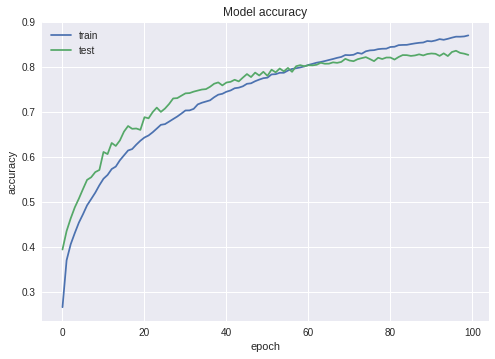

In [85]:
plotAccuracy(history7.history)

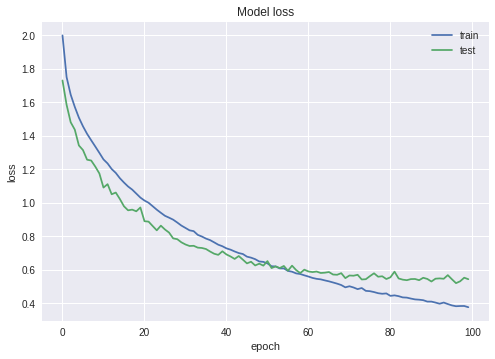

In [86]:
plotLoss(history7.history)

**Overfitting of the model is just minized and delayed as it can be seen from the plots with comparitively less difference in model losses.**

###Config 8 - Trying to increase dropout rate on config 6

In [0]:
model8 = Sequential()
model8.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model8.add(PReLU())
model8.add(Conv2D(64, (3, 3)))
model8.add(PReLU())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(SpatialDropout2D(0.25))

model8.add(Conv2D(128, (3, 3), padding='same'))
model8.add(PReLU())
model8.add(Conv2D(256, (3, 3)))
model8.add(PReLU())
model8.add(MaxPooling2D(pool_size=(2, 2)))
model8.add(SpatialDropout2D(0.25))

model8.add(Flatten())
model8.add(Dense(512))
model8.add(PReLU())
model8.add(Dropout(0.2))
model8.add(Dense(1024))
model8.add(PReLU())
model8.add(Dropout(0.2))
model8.add(Dense(num_classes))
model8.add(Activation('softmax'))

In [108]:
model8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_127 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_29 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 30, 30, 64)        18496     
_________________________________________________________________
p_re_lu_30 (PReLU)           (None, 30, 30, 64)        57600     
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
spatial_dropout2d_60 (Spatia (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_129 (Conv2D)          (None, 15, 15, 128)       73856     
__________

In [97]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model8.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history8 = model8.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 37s 188ms/step - loss: 2.0205 - acc: 0.2589 - val_loss: 1.7062 - val_acc: 0.3919
Epoch 2/100
196/196 [==============================] - 34s 171ms/step - loss: 1.7417 - acc: 0.3692 - val_loss: 1.5203 - val_acc: 0.4440
Epoch 3/100
196/196 [==============================] - 34s 172ms/step - loss: 1.6192 - acc: 0.4174 - val_loss: 1.4434 - val_acc: 0.4857
Epoch 4/100
196/196 [==============================] - 34s 172ms/step - loss: 1.5315 - acc: 0.4470 - val_loss: 1.4031 - val_acc: 0.5000
Epoch 5/100
196/196 [==============================] - 34s 173ms/step - loss: 1.4571 - acc: 0.4767 - val_loss: 1.3368 - val_acc: 0.5170
Epoch 6/100
196/196 [==============================] - 34s 173ms/step - loss: 1.3899 - acc: 0.5022 - val_loss: 1.2498 - val_acc: 0.5536
Epoch 7/100
196/196 [==============================] - 34s 172ms/step - loss: 1.3383 - acc: 0.5200 - val_loss: 1.1936 - val_acc: 0.5742
Epoch 8/100
196/196 [===========================

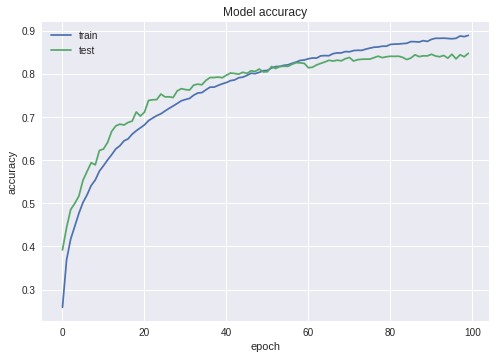

In [98]:
plotAccuracy(history8.history)

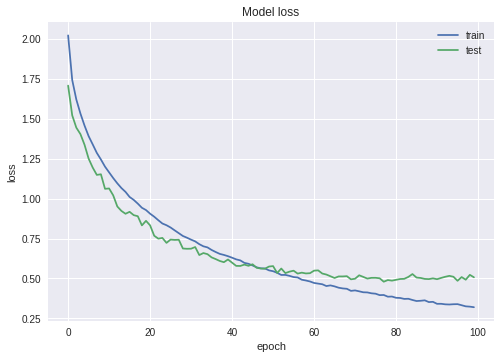

In [99]:
plotLoss(history8.history)

**Not a significant difference between the config 6 and config 8 models.**

###Config 9 - Simplest CNN

In [0]:
model9 = Sequential()
model9.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model9.add(PReLU())
model9.add(MaxPooling2D(pool_size=(2, 2)))
model9.add(SpatialDropout2D(0.2))

model9.add(Flatten())
model9.add(Dense(512))
model9.add(PReLU())
model9.add(Dropout(0.2))
model9.add(Dense(num_classes))
model9.add(Activation('softmax'))

In [107]:
model9.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_133 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_37 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
spatial_dropout2d_63 (Spatia (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_31 (Flatten)         (None, 8192)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 512)               4194816   
_________________________________________________________________
p_re_lu_38 (PReLU)           (None, 512)               512       
__________

In [103]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model9.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history9 = model9.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 29s 146ms/step - loss: 1.9169 - acc: 0.3141 - val_loss: 1.6626 - val_acc: 0.4214
Epoch 2/100
196/196 [==============================] - 26s 133ms/step - loss: 1.6996 - acc: 0.4023 - val_loss: 1.4999 - val_acc: 0.4866
Epoch 3/100
196/196 [==============================] - 27s 136ms/step - loss: 1.6016 - acc: 0.4355 - val_loss: 1.4511 - val_acc: 0.5004
Epoch 4/100
196/196 [==============================] - 26s 134ms/step - loss: 1.5380 - acc: 0.4592 - val_loss: 1.3952 - val_acc: 0.5128
Epoch 5/100
196/196 [==============================] - 27s 136ms/step - loss: 1.4951 - acc: 0.4754 - val_loss: 1.3283 - val_acc: 0.5375
Epoch 6/100
196/196 [==============================] - 27s 136ms/step - loss: 1.4557 - acc: 0.4895 - val_loss: 1.3192 - val_acc: 0.5447
Epoch 7/100
196/196 [==============================] - 27s 136ms/step - loss: 1.4269 - acc: 0.5001 - val_loss: 1.2976 - val_acc: 0.5490
Epoch 8/100
196/196 [===========================

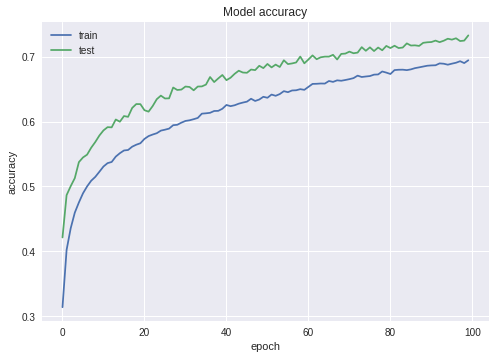

In [104]:
plotAccuracy(history9.history)

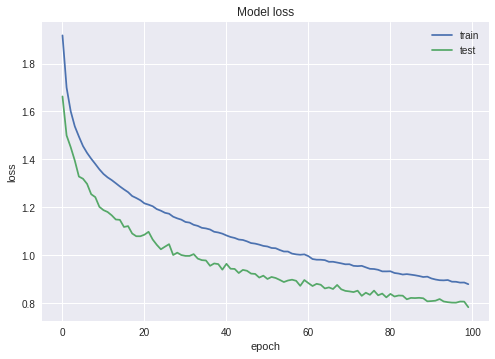

In [105]:
plotLoss(history9.history)

**As expected, the model is underfitting and more conv layers needs to be added so that effective weights can be determined.**

###Config 10 - Adding 1 more convolutional layer

In [0]:
model10 = Sequential()
model10.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model10.add(PReLU())
model10.add(MaxPooling2D(pool_size=(2, 2)))
model10.add(SpatialDropout2D(0.2))

model10.add(Conv2D(64, (3, 3), padding='same'))
model10.add(PReLU())
model10.add(MaxPooling2D(pool_size=(2, 2)))
model10.add(SpatialDropout2D(0.2))

model10.add(Flatten())
model10.add(Dense(512))
model10.add(PReLU())
model10.add(Dropout(0.2))
model10.add(Dense(num_classes))
model10.add(Activation('softmax'))

In [116]:
model10.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_134 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_39 (PReLU)           (None, 32, 32, 32)        32768     
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
spatial_dropout2d_64 (Spatia (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_135 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
p_re_lu_40 (PReLU)           (None, 16, 16, 64)        16384     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 8, 8, 64)          0         
__________

In [117]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model10.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history10 = model10.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 30s 154ms/step - loss: 2.0741 - acc: 0.2473 - val_loss: 1.8058 - val_acc: 0.3806
Epoch 2/100
196/196 [==============================] - 27s 137ms/step - loss: 1.8355 - acc: 0.3486 - val_loss: 1.6253 - val_acc: 0.4348
Epoch 3/100
196/196 [==============================] - 27s 140ms/step - loss: 1.7066 - acc: 0.3983 - val_loss: 1.5183 - val_acc: 0.4636
Epoch 4/100
196/196 [==============================] - 28s 141ms/step - loss: 1.6279 - acc: 0.4246 - val_loss: 1.4320 - val_acc: 0.4968
Epoch 5/100
196/196 [==============================] - 28s 140ms/step - loss: 1.5785 - acc: 0.4417 - val_loss: 1.4006 - val_acc: 0.5081
Epoch 6/100
196/196 [==============================] - 28s 142ms/step - loss: 1.5359 - acc: 0.4568 - val_loss: 1.3408 - val_acc: 0.5298
Epoch 7/100
196/196 [==============================] - 27s 139ms/step - loss: 1.4958 - acc: 0.4701 - val_loss: 1.2998 - val_acc: 0.5455
Epoch 8/100
196/196 [===========================

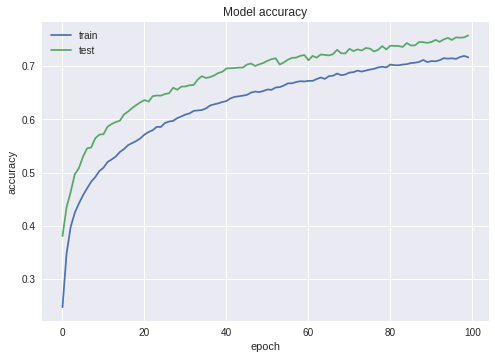

In [118]:
plotAccuracy(history10.history)

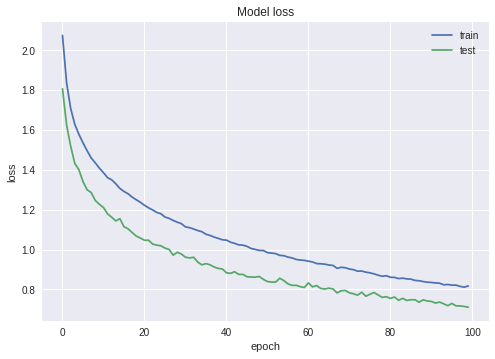

In [119]:
plotLoss(history10.history)

**There is some increase in the model accuracy as compared to the previous model but it is still underfitting and more deeper networks have to be made.**

###Config 11 - Added 2 more convolotuional layers

In [0]:
model11 = Sequential()
model11.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model11.add(PReLU())
model11.add(Conv2D(64, (3, 3), padding='same'))
model11.add(PReLU())
model11.add(MaxPooling2D(pool_size=(2, 2)))
model11.add(SpatialDropout2D(0.2))

model11.add(Conv2D(128, (3, 3), padding='same'))
model11.add(PReLU())
model11.add(Conv2D(256, (3, 3), padding='same'))
model11.add(PReLU())
model11.add(MaxPooling2D(pool_size=(2, 2)))
model11.add(SpatialDropout2D(0.2))

model11.add(Flatten())
model11.add(Dense(512))
model11.add(PReLU())
model11.add(Dropout(0.2))
model11.add(Dense(num_classes))
model11.add(Activation('softmax'))

In [18]:
model11.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 32, 32, 64)        65536     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_5 (Spatial (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 128)       73856     
__________

In [19]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model11.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history11 = model11.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 36s 184ms/step - loss: 1.9258 - acc: 0.3031 - val_loss: 1.6163 - val_acc: 0.4237
Epoch 2/100
196/196 [==============================] - 35s 177ms/step - loss: 1.6548 - acc: 0.4044 - val_loss: 1.4354 - val_acc: 0.4850
Epoch 3/100
196/196 [==============================] - 34s 175ms/step - loss: 1.5385 - acc: 0.4480 - val_loss: 1.3517 - val_acc: 0.5156
Epoch 4/100
196/196 [==============================] - 34s 171ms/step - loss: 1.4443 - acc: 0.4848 - val_loss: 1.2850 - val_acc: 0.5445
Epoch 5/100
196/196 [==============================] - 34s 173ms/step - loss: 1.3703 - acc: 0.5126 - val_loss: 1.2052 - val_acc: 0.5719
Epoch 6/100
196/196 [==============================] - 34s 172ms/step - loss: 1.3100 - acc: 0.5357 - val_loss: 1.1543 - val_acc: 0.5939
Epoch 7/100
196/196 [==============================] - 34s 173ms/step - loss: 1.2573 - acc: 0.5511 - val_loss: 1.0648 - val_acc: 0.6203
Epoch 8/100
196/196 [===========================

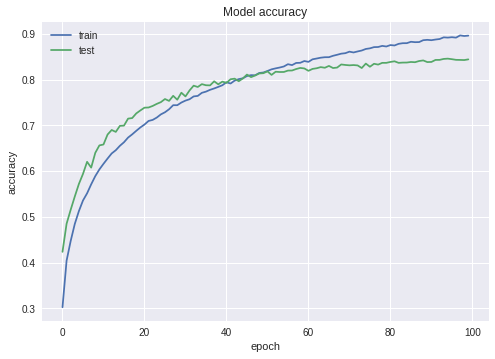

In [20]:
plotAccuracy(history11.history)

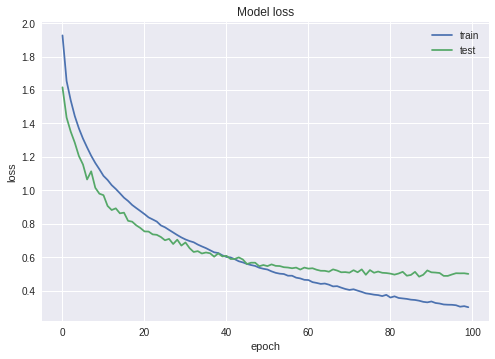

In [21]:
plotLoss(history11.history)

**This is a better model but there is high difference in the slopes of the train and test plots of accuracy and losses. This is probably because of high bias in the network.**

###Config 12 - Removing Bias from 2 convolutional layers 

In [0]:
model12 = Sequential()
model12.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model12.add(PReLU())
model12.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model12.add(PReLU())
model12.add(MaxPooling2D(pool_size=(2, 2)))
model12.add(SpatialDropout2D(0.2))

model12.add(Conv2D(128, (3, 3), padding='same'))
model12.add(PReLU())
model12.add(Conv2D(256, (3, 3), padding='same', use_bias=False))
model12.add(PReLU())
model12.add(MaxPooling2D(pool_size=(2, 2)))
model12.add(SpatialDropout2D(0.2))

model12.add(Flatten())
model12.add(Dense(512))
model12.add(PReLU())
model12.add(Dropout(0.2))
model12.add(Dense(1024))
model12.add(PReLU())
model12.add(Dropout(0.2))
model12.add(Dense(num_classes))
model12.add(Activation('softmax'))

In [23]:
model12.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_6 (PReLU)            (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        18432     
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 32, 32, 64)        65536     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_7 (Spatial (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 16, 16, 128)       73856     
__________

In [24]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model12.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history12 = model12.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 31s 161ms/step - loss: 1.9600 - acc: 0.2810 - val_loss: 1.6245 - val_acc: 0.4154
Epoch 2/100
196/196 [==============================] - 30s 154ms/step - loss: 1.6699 - acc: 0.3999 - val_loss: 1.4785 - val_acc: 0.4698
Epoch 3/100
196/196 [==============================] - 30s 153ms/step - loss: 1.5475 - acc: 0.4417 - val_loss: 1.4432 - val_acc: 0.4720
Epoch 4/100
196/196 [==============================] - 30s 151ms/step - loss: 1.4481 - acc: 0.4789 - val_loss: 1.2900 - val_acc: 0.5378
Epoch 5/100
196/196 [==============================] - 29s 150ms/step - loss: 1.3579 - acc: 0.5115 - val_loss: 1.1956 - val_acc: 0.5675
Epoch 6/100
196/196 [==============================] - 30s 151ms/step - loss: 1.2832 - acc: 0.5395 - val_loss: 1.1594 - val_acc: 0.5898
Epoch 7/100
196/196 [==============================] - 29s 150ms/step - loss: 1.2245 - acc: 0.5651 - val_loss: 1.1591 - val_acc: 0.5963
Epoch 8/100
196/196 [===========================

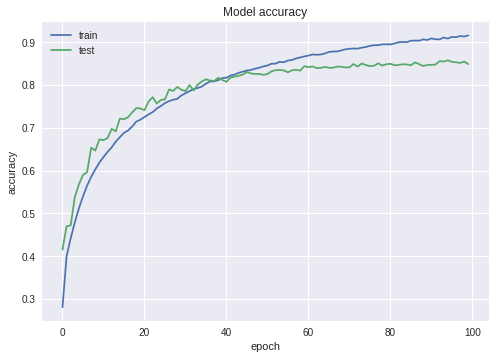

In [25]:
plotAccuracy(history12.history)

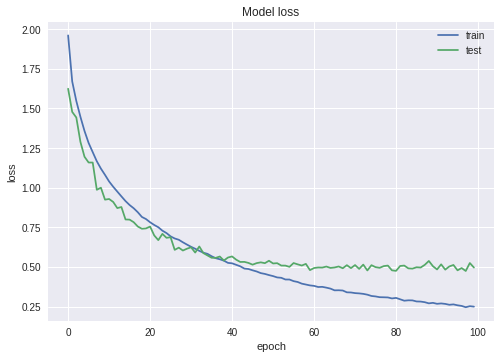

In [26]:
plotLoss(history12.history)

**The slope in these plots look better than the previous network plots. There is a difference between the training and the testing accuracies which might lead to overfitting.**

###Config 13 - Adding 2 more Max pooling layers

In [0]:
model13 = Sequential()
model13.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
model13.add(PReLU())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model13.add(PReLU())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(SpatialDropout2D(0.2))

model13.add(Conv2D(128, (3, 3), padding='same'))
model13.add(PReLU())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(Conv2D(256, (3, 3), padding='same', use_bias=False))
model13.add(PReLU())
model13.add(MaxPooling2D(pool_size=(2, 2)))
model13.add(SpatialDropout2D(0.2))

model13.add(Flatten())
model13.add(Dense(512))
model13.add(PReLU())
model13.add(Dropout(0.2))
model13.add(Dense(1024))
model13.add(PReLU())
model13.add(Dropout(0.2))
model13.add(Dense(num_classes))
model13.add(Activation('softmax'))

In [12]:
model13.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 32, 32, 32)        32768     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18432     
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 16, 16, 64)        16384     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 8, 8, 64)          0         
__________

In [13]:
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)
model13.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
history13 = model13.fit_generator(datagen.flow(x_train, y_train, batch_size=256), epochs=epochs,
                    validation_data=(x_test, y_test), workers=1)

Epoch 1/100
196/196 [==============================] - 32s 163ms/step - loss: 2.0732 - acc: 0.2279 - val_loss: 1.8332 - val_acc: 0.3408
Epoch 2/100
196/196 [==============================] - 28s 142ms/step - loss: 1.8482 - acc: 0.3245 - val_loss: 1.6696 - val_acc: 0.3976
Epoch 3/100
196/196 [==============================] - 28s 141ms/step - loss: 1.7168 - acc: 0.3770 - val_loss: 1.6371 - val_acc: 0.4097
Epoch 4/100
196/196 [==============================] - 28s 144ms/step - loss: 1.6251 - acc: 0.4091 - val_loss: 1.4672 - val_acc: 0.4668
Epoch 5/100
196/196 [==============================] - 28s 144ms/step - loss: 1.5646 - acc: 0.4326 - val_loss: 1.5346 - val_acc: 0.4447
Epoch 6/100
196/196 [==============================] - 29s 146ms/step - loss: 1.5102 - acc: 0.4522 - val_loss: 1.3971 - val_acc: 0.4972
Epoch 7/100
196/196 [==============================] - 28s 142ms/step - loss: 1.4660 - acc: 0.4681 - val_loss: 1.3769 - val_acc: 0.4975
Epoch 8/100
196/196 [===========================

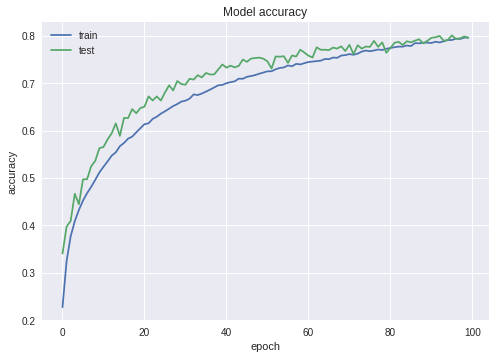

In [14]:
plotAccuracy(history13.history)

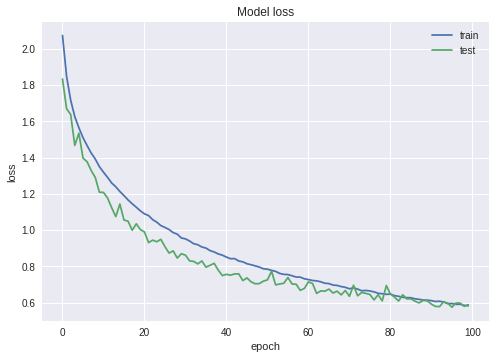

In [15]:
plotLoss(history13.history)

**Definitly these plots are better than the previous network plots but there is a cost paid by the network. To attain stability, dimension reduction is performed but there is a hefty decrease in accuracy of about 7-8%.**

##Best CNN model
### Config 12

In [46]:
model12.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
p_re_lu_7 (PReLU)            (None, 32, 32, 32)        32768     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)        18432     
_________________________________________________________________
p_re_lu_8 (PReLU)            (None, 32, 32, 64)        65536     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
spatial_dropout2d_3 (Spatial (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       73856     
__________

**Saving the model in local environment**

In [0]:
model12.save('Final_cnn_model.h5')

**Using PyDrive package to upload the saved model to google drive**

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
model_config = drive.CreateFile()

In [0]:
model_config.SetContentFile('Final_cnn_model.h5')

In [0]:
model_config.Upload()